## Figure of the base case's bottom concentration

In [1]:
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib.gridspec as gspec
import matplotlib as mpl
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import seaborn as sns
import xarray as xr
import canyon_tools.readout_tools as rout
import canyon_tools.savitzky_golay as sg

In [27]:
def calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4):
    """-----------------------------------------------------------------------------
    calc_rho calculates the density using a linear equation of state.
    
    INPUT:
    RhoRef : reference density at the same z as T and S slices. Can be a scalar or a 
             vector, depending on the size of T and S.
    T, S   : should be at least 2D arrays in coordinate order (..., Y , X ) 
    alpha = 2.0E-4 # 1/degC, thermal expansion coefficient
    beta = 7.4E-4, haline expansion coefficient
    OUTPUT:
    rho - Density [...,ny,nx]
    -----------------------------------------------------------------------------"""
    
    #Linear eq. of state 
    rho = RhoRef*(np.ones(np.shape(T)) - alpha*(T[...,:,:]) + beta*(S[...,:,:]))
    return rho

def call_unstag(t):
    UU,VV = rout.unstagger(state.U.isel(T=t),state.V.isel(T=t))
    return(UU,VV)


def call_rho(t,yslice,xslice):
    T = state.Temp.isel(T=t,Y=yslice,X=xslice)
    S = state.S.isel(T=t,Y=yslice,X=xslice)
    rho = calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4)
    return(rho) 


In [2]:
def mask2DCanyon(bathy, sbdepth=-152.5):
    '''Mask out the canyon from the shelf.
    bathy : depths 2D array from the grid file
    sbdepth: shelf depth, always negative float 
    Returns mask'''
    
    bathyMasked = np.ma.masked_less(-bathy, -152.5)
    return(bathyMasked.mask)

def ConcArea(Tr, hfac, ra, bathy, sbdepth=-152.5):
    '''Tr: Tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx)
       Conc = cocnetration near bottom (nt,ny,nx)'''
    
    ConcArea = np.empty((19,360,360))
    Conc = np.empty((19,360,360))
    ConcFiltered = np.empty((19,360,360))
    Area = np.empty((19,360,360))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*89 - BottomInd # Get index of unreversed z axis
    
    print(np.shape(BottomInd))
    for tt in range(19):
        #print(tt)
        for j in range(360):
            for i in range(360):
                TrBottom = Tr[tt,BottomInd[i,j],i,j]
                if TrBottom > 0.0:
                    ConcArea[tt,i,j] = TrBottom*ra[i,j]
                    Conc[tt,i,j] = TrBottom
                    Area[tt,i,j] = ra[i,j]
                else:
                    ConcArea[tt,i,j] = np.NaN
                    Conc[tt,i,j] = np.NaN
                    Area[tt,i,j] = np.NaN
                    
            # Filter step noise
            ConcFiltered[tt,:,j] = sg.savitzky_golay(Conc[tt,:,j], 7,3) 
                
    print(np.shape(ConcArea))
    
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    return (ConcArea,
            np.ma.masked_array(ConcFiltered, mask=maskShelf),
            Area,
           )

In [54]:
# Cross-shelf velocity, Plot1
def Plot1(gs_ax,Tr_slice): 
    '''gs_ax: grid handle
       Tr_slice: tracer concentration sliced in x-z (nt,nz,nx)
       tslice: advective phase slice to average over.
       yind: cross-shore index of the plot
    '''
    ax = plt.subplot(gs_ax)
    Trmin = 0
    Trmax = 11
    rho_min = 1020.4-1000.0
    rho_max = 1021.4-1000.0 # 1022.4 if y=230,1021.4 if y=260
    
    density = call_rho(tslice,yind,xslice)
    csU = np.linspace(Trmin,Trmax,num=31)
    csU2 = np.linspace(Trmin,Trmax,num=16)
    #csU2 = np.linspace(rho_min,rho_max,num=15)
    
    Trplot = np.ma.array(np.nanmean(Tr_slice.isel(T=tslice).data,0),mask=MaskC[:,yind])
    mesh = ax.contourf(grid.X/1000,grid.Z[:22],Trplot[:22,:],csU,cmap=cmo.cm.matter)
    
    #cax,kw = mpl.colorbar.make_axes([ax],location='right',anchor=(1,0),shrink=1.1)
    #cb = plt.colorbar(mesh, cax=cax,ticks=[np.linspace(Trmin, Trmax,8) ],format='%.1f',**kw)
    
    CS = ax.contour(grid.X/1000,grid.Z[:22],
                     Trplot[:22,:],
                     csU2,colors='k',linewidths=[0.75] )
    plt.clabel(CS,inline=True, fmt='%.1f')
    
    #CS = ax.contour(grid.X[xslice]/1000,grid.Z[:22],
    #                 np.ma.array(np.nanmean(density[:,:22,:].data-1000,axis=0),mask=MaskC[:22,yind,:]),
    #                 csU2,colors='k',linewidths=[0.75] )
    #plt.clabel(CS,inline=True, fmt='%.1f')
    
    ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
    ax.set_ylabel('Depth (m)',labelpad=0.3)
    ax.text(0.0,0.95,'Tr (Mol/l)',transform=ax.transAxes)
    

In [60]:
# Cross-shelf velocity, Plot1
def Plot2(gs_ax,Tr_slice,xind): 
    '''gs_ax: grid handle
       Tr_slice: tracer concentration sliced in y-z (nt,nz,ny)
       tslice: advective phase slice to average over.
       xind: cross-shore index of the plot
    '''
    ax = plt.subplot(gs_ax)
    Trmin = 0
    Trmax = 11
    rho_min = 1020.4-1000.0
    rho_max = 1021.4-1000.0 # 1022.4 if y=230,1021.4 if y=260
    
    density = call_rho(tslice,yslice,xind)
    csU = np.linspace(Trmin,Trmax,num=31)
    csU2 = np.linspace(Trmin,Trmax,num=16)
    #csU2 = np.linspace(rho_min,rho_max,num=15)
    
    Trplot = np.ma.array(np.nanmean(Tr_slice.isel(T=tslice).data,0),mask=MaskC[:,xind])
    mesh = ax.contourf(grid.Z[:22],grid.Y[225:]/1000,np.transpose(Trplot[:22,225:]),csU,cmap=cmo.cm.matter)
    
    #cax,kw = mpl.colorbar.make_axes([ax],location='right',anchor=(1,0),shrink=1.1)
    #cb = plt.colorbar(mesh, cax=cax,ticks=[np.linspace(Trmin, Trmax,8) ],format='%.1f',**kw)
    
    CS = ax.contour(grid.Z[:22],grid.Y[225:]/1000,
                     np.transpose(Trplot[:22,225:]),
                     csU2,colors='k',linewidths=[0.75] )
    plt.clabel(CS,inline=True, fmt='%.1f')
    
    #CS = ax.contour(grid.X[xslice]/1000,grid.Z[:22],
    #                 np.ma.array(np.nanmean(density[:,:22,:].data-1000,axis=0),mask=MaskC[:22,yind,:]),
    #                 csU2,colors='k',linewidths=[0.75] )
    #plt.clabel(CS,inline=True, fmt='%.1f')
    
    ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
    ax.set_xlabel('Depth (m)',labelpad=0.3)
    ax.text(0.0,0.95,'Tr (Mol/l)',transform=ax.transAxes)
    

In [4]:
# Grid, state and tracers datasets of base case
grid_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
grid = xr.open_dataset(grid_file)

state_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/stateGlob.nc' 
state = xr.open_dataset(state_file)

ptracers_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/ptracersGlob.nc'
ptracers = xr.open_dataset(ptracers_file)

#RhoRef = np.squeeze(rdmds('/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/RhoRef'))
RhoRef = 999.79998779 # It is constant in all my runs, can't run rdmds

In [7]:
# General input
nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 

yind = 267 # y index for alongshore cross-section
#yind2 = 250 # y index for alongshore cross-section

xslice=slice(0,360)
yslice=slice(100,300)

xslice_spd = slice(60,300)
yslice_spd = slice(150,280)

x_qslice = slice(60,300,15)
y_qslice = slice(150,280,15)

tslice = slice(8,16)

xind = 180
yslice_u = slice(150,300)
zind = 27

# plot 5
xind_umean = 120
yslice_umean = slice(150,267)
zslice_umean = slice(25,50)
tslice_umean = slice(0,20)

# plot 6
yslice_bac = slice(225,300)
xslice_bac = slice(100,360)

hFacmasked = np.ma.masked_values(grid.HFacC.data, 0)
MaskC = np.ma.getmask(hFacmasked)

MaskExpand = np.expand_dims(MaskC,0) 
MaskExpand = MaskExpand + np.zeros((ptracers.Tr1).shape)    

In [6]:
ConcArea, ConcFilt, Area = ConcArea(ptracers.Tr1.data, grid.HFacC.data, grid.rA.data, grid.Depth.data)

(360, 360)


/home/kramosmu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(19, 360, 360)


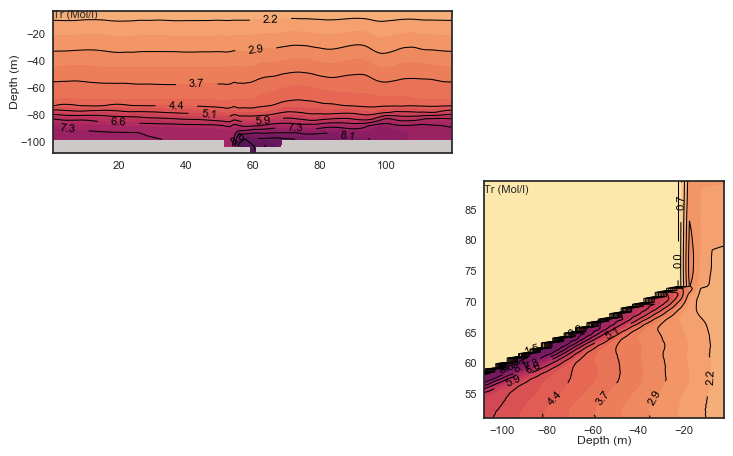

In [61]:
sns.set_context('paper')
sns.set_style('white')

plt.rcParams['font.size'] = 8.0

f = plt.figure(figsize = (7.4,4.6)) # 19.0cm = 7.4in, 115cm = 4.52in

gs0 = gspec.GridSpec(2, 2, height_ratios=[0.6,1], width_ratios=[1,0.6])

Plot1(gs0[0,0],ptracers.Tr1.isel(Y=267)) # x-z contours conc

Plot2(gs0[1,1],ptracers.Tr1.isel(X=250),250) # bottom concentration

#Plot3(gs0[1,1]) # y-z contours conc


plt.tight_layout()

plt.savefig('fig_BottomConcBase.pdf',format='pdf')
